# Configuration

In [ ]:
# --- Imports
import os
from pathlib import Path
import seaborn as sns
from scipy import stats


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


# Optional irsdk (for .ibt)
try:
    import irsdk
    IRSDK_AVAILABLE = True
except Exception:
    IRSDK_AVAILABLE = False

print(f"irsdk available   : {IRSDK_AVAILABLE}")

# --- Paths & Parameters
USE_IBT = True  # set True to read a .ibt with irsdk if available


# Core pipeline settings
N_SECTORS = 4               # number of sectors to split the track
BASE_GRID_LEN = 1000
TOPK_PERCENT = 0.30          # robust sector reference: median of fastest top K%
PACE_THRESHOLD_MS = 3000.0   # drop laps whose sum of positive sector losses > 2s
CLIP_MS = 1500.0             # clip training target (ms)
SEQ_LEN = 128                # per-sector resampling for stability
SEED = 42



irsdk available   : True


# Dataset Loading

In [28]:
# --- Configuration ---
IBT_FILES = [
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt"), 
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt")
]
USE_IBT = True
IRSDK_AVAILABLE = True 

def load_from_ibt(ibt_path: Path) -> pd.DataFrame:
    """
    Loads binary IBT file using irsdk.
    """
    if not IRSDK_AVAILABLE:
        raise RuntimeError("irsdk is not available in this environment.")
    if not ibt_path.exists():
        raise FileNotFoundError(f".ibt file not found: {ibt_path}")
    
    ibt = irsdk.IBT()
    try:
        ibt.open(str(ibt_path))
        channels = ['SessionTime','Lap','Speed','RPM','Throttle','Brake',
                    'LapDistPct','Lat','Lon','SteeringWheelAngle','Gear',
                    'LatAccel','LongAccel']
        data = {ch: ibt.get_all(ch) for ch in channels}
    except Exception as e:
        print(f"[ERROR] Failed to open {ibt_path}: {e}")
        return pd.DataFrame() 
    finally:
        ibt.close()
    return pd.DataFrame(data)

def basic_clean_and_units(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs basic data cleaning (Inf/NaN removal) and unit conversion.
    """
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    if "Speed_KPH" not in df.columns and "Speed" in df.columns:
        df["Speed_KPH"] = df["Speed"] * 3.6
    if "Throttle_Pct" not in df.columns and "Throttle" in df.columns:
        df["Throttle_Pct"] = df["Throttle"] * 100.0
    if "Brake_Pct" not in df.columns and "Brake" in df.columns:
        df["Brake_Pct"] = df["Brake"] * 100.0
    return df

def process_multi_session_data(file_list):
    """
    Loads multiple IBT files, cleans them individually, and stitches them 
    into a single continuous timeline for stochastic analysis.
    """
    processed_dfs = []
    
    # Global Offset Controller
    global_lap_counter = 0 
    
    print(f"[PIPELINE] Starting ingestion of {len(file_list)} files...")

    for i, file_path in enumerate(file_list):
        print(f"   -> Processing File {i+1}: {file_path.name}")
        
        # 1. Load & Basic Units
        raw_df = load_from_ibt(file_path)
        if raw_df.empty: continue
        current_df = basic_clean_and_units(raw_df)
        
        # --- CRITICAL STEP: INVALID LAP REMOVAL ---
        # Identify valid laps for THIS specific file.
        # Usually, we remove the first (Outlap/Warmup) and the last (Inlap/Incomplete).
        min_lap = current_df['Lap'].min()
        max_lap = current_df['Lap'].max()
        
        # Rule: Keep only laps strictly between min and max.
        # This ensures we remove the cold Outlap and the incomplete Inlap.
        current_df = current_df[(current_df['Lap'] > min_lap) & (current_df['Lap'] < max_lap)].copy()
        
        if current_df.empty:
            print(f"      [WARNING] File {i+1} resulted in empty data after filtering outlaps.")
            continue
            
        # 2. Re-indexing (Stitching)
        # Now that we have only clean laps, we re-number them to follow the global sequence.
        # Example: File 1 has 15 laps. File 2 has 15 laps.
        # Final Result: Laps 1 to 30 continuous.
        
        # Normalize local lap count to start at 1 (removes local offset)
        current_df['Lap'] = current_df['Lap'] - current_df['Lap'].min() + 1
        
        # Add the global counter to continue the sequence
        current_df['Lap'] += global_lap_counter
        
        # Update the global counter for the next file iteration
        laps_in_this_file = current_df['Lap'].nunique()
        global_lap_last_val = current_df['Lap'].max()
        
        print(f"      [INFO] Extracted {laps_in_this_file} valid laps. Mapped to Global Laps: {current_df['Lap'].min()} -> {current_df['Lap'].max()}")
        
        global_lap_counter = global_lap_last_val
            
        processed_dfs.append(current_df)

    # 4. Concatenate
    if processed_dfs:
        full_df = pd.concat(processed_dfs, ignore_index=True)
        
        # Recalculate SessionTime to be continuous (Optional, but recommended for plotting X(t))
        # Create a synthetic continuous time based on index
        # (Assuming constant sampling rate, e.g., 60Hz)
        full_df['SessionTime'] = np.arange(len(full_df)) * (1/60.0) 
        
        print(f"[PIPELINE] Complete. Total Data Points: {len(full_df)}")
        print(f"[PIPELINE] Total Valid Laps: {full_df['Lap'].nunique()}")
        return full_df
    else:
        raise RuntimeError("No data could be loaded.")

# --- Execute Pipeline ---
if USE_IBT:
    df = process_multi_session_data(IBT_FILES)
    

[PIPELINE] Starting ingestion of 2 files...
   -> Processing File 1: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt
      [INFO] Extracted 13 valid laps. Mapped to Global Laps: 1 -> 13
   -> Processing File 2: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt
      [INFO] Extracted 18 valid laps. Mapped to Global Laps: 14 -> 31
[PIPELINE] Complete. Total Data Points: 185589
[PIPELINE] Total Valid Laps: 31


## Quick sanity check

In [3]:

print(df.head())
print(df.tail())

   SessionTime  Lap      Speed          RPM  Throttle  Brake  LapDistPct  \
0     0.000000    1  24.189777  6353.956543       1.0    0.0    0.000053   
1     0.016667    1  24.250711  6355.349121       1.0    0.0    0.000165   
2     0.033333    1  24.312675  6355.340820       1.0    0.0    0.000277   
3     0.050000    1  24.373638  6352.822266       1.0    0.0    0.000389   
4     0.066667    1  24.433487  6350.770020       1.0    0.0    0.000502   

         Lat        Lon  SteeringWheelAngle  Gear  LatAccel  LongAccel  \
0  35.352290 -80.685640            0.020582     1 -0.767404   3.767957   
1  35.352286 -80.685641            0.020124     1 -0.446361   3.842361   
2  35.352283 -80.685642            0.019439     1 -0.492839   3.838492   
3  35.352279 -80.685643            0.019439     1 -0.550015   3.775527   
4  35.352276 -80.685645            0.019439     1 -0.618664   3.716111   

   Speed_KPH  Throttle_Pct  Brake_Pct  
0  87.083199         100.0        0.0  
1  87.302561      

In [34]:
# --- Helper Function: Time Formatting ---
def format_lap_time(seconds):
    """Formats time in seconds to mm:ss.ms"""
    minutes = int(seconds // 60)
    rem_seconds = int(seconds % 60)
    milliseconds = int((seconds - int(seconds)) * 1000)
    return f"{minutes:02d}:{rem_seconds:02d}.{milliseconds:03d}"

def inspect_concatenated_df(df_input):
    """
    Analyzes the final stitched dataframe to verify lap continuity and consistency.
    """
    print(f"--- CONCATENATED DATAFRAME INSPECTION ---")
    print(f"Total Data Points: {len(df_input)}")
    
    # Get unique laps sorted
    unique_laps = sorted(df_input['Lap'].unique())
    total_laps = len(unique_laps)
    
    print(f"Total Laps Detected: {total_laps} (Laps {min(unique_laps)} to {max(unique_laps)})")
    print("-" * 65)
    print(f"{'Lap ID':<10} | {'Duration (s)':<15} | {'Formatted':<15} | {'Status'}")
    print("-" * 65)
    
    lap_durations = []
    
    for lap_idx in unique_laps:
        # Extract data for this specific lap
        lap_data = df_input[df_input['Lap'] == lap_idx]
        
        # Calculate duration
        # Note: Since we stitched times, max - min should still give the correct relative duration
        duration = lap_data['SessionTime'].max() - lap_data['SessionTime'].min()
        lap_durations.append(duration)
        
        # Basic status check (Adjust thresholds for your car/track combo)
        # Charlotte Roval in MX5 is approx 1:25 to 1:30 usually?
        status = "OK"
        if duration < 60: status = "⚠️ Short/Suspicious"
        elif duration > 120: status = "⚠️ Slow/Traffic?"
        
        print(f"{int(lap_idx):<10} | {duration:<15.4f} | {format_lap_time(duration):<15} | {status}")
        
    print("-" * 65)
    
    # Summary Statistics
    if lap_durations:
        mean_time = np.mean(lap_durations)
        std_time = np.std(lap_durations)
        print(f"SUMMARY STATISTICS:")
        print(f"   -> Average Lap Time: {format_lap_time(mean_time)} ({mean_time:.4f} s)")
        print(f"   -> Consistency (Std Dev): {std_time:.4f} s")
        if std_time < 0.5:
            print("   -> RATING: Excellent Consistency! (Ideal for Stochastic Analysis)")
        elif std_time < 1.0:
            print("   -> RATING: Good Consistency.")
        else:
            print("   -> RATING: High Variance (Check for traffic or mistakes).")

# --- Execute Inspection ---
if 'df' in locals() and not df.empty:
    df_selected = df[(df['Lap'] >= 2) & (df['Lap'] <= 30)]
    inspect_concatenated_df(df_selected)
else:
    print("[ERROR] 'df' not found. Please run the pipeline cell first.")

--- CONCATENATED DATAFRAME INSPECTION ---
Total Data Points: 172625
Total Laps Detected: 29 (Laps 2 to 30)
-----------------------------------------------------------------
Lap ID     | Duration (s)    | Formatted       | Status
-----------------------------------------------------------------
2          | 103.7000        | 01:43.700       | OK
3          | 99.9167         | 01:39.916       | OK
4          | 100.0167        | 01:40.016       | OK
5          | 99.3333         | 01:39.333       | OK
6          | 98.9833         | 01:38.983       | OK
7          | 99.1500         | 01:39.149       | OK
8          | 102.1000        | 01:42.100       | OK
9          | 98.9167         | 01:38.916       | OK
10         | 100.9167        | 01:40.916       | OK
11         | 99.1000         | 01:39.099       | OK
12         | 98.7833         | 01:38.783       | OK
13         | 99.4500         | 01:39.449       | OK
14         | 99.2500         | 01:39.250       | OK
15         | 98.0833         

# 2) Statistical Properties Analysis

[INFO] Analyzing Laps: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]


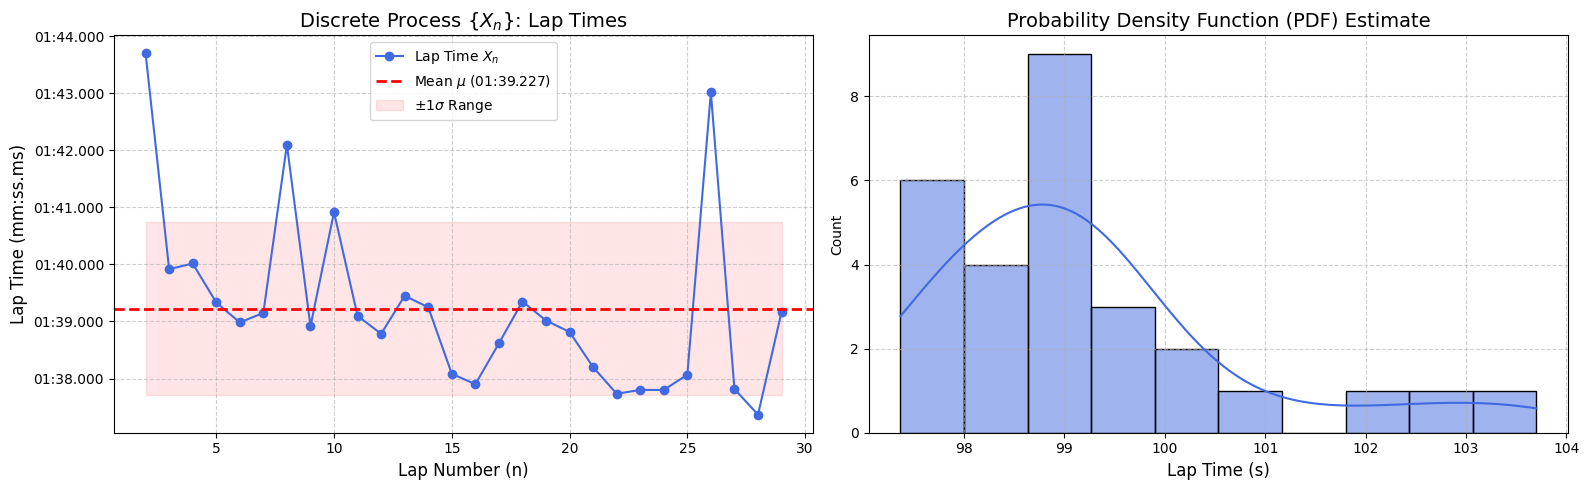

[RESULTS] Discrete Process {X_n} Statistics:
   - Mean (E[X]): 99.2274 s (01:39.227)
   - Std Dev (sigma): 1.5218 s


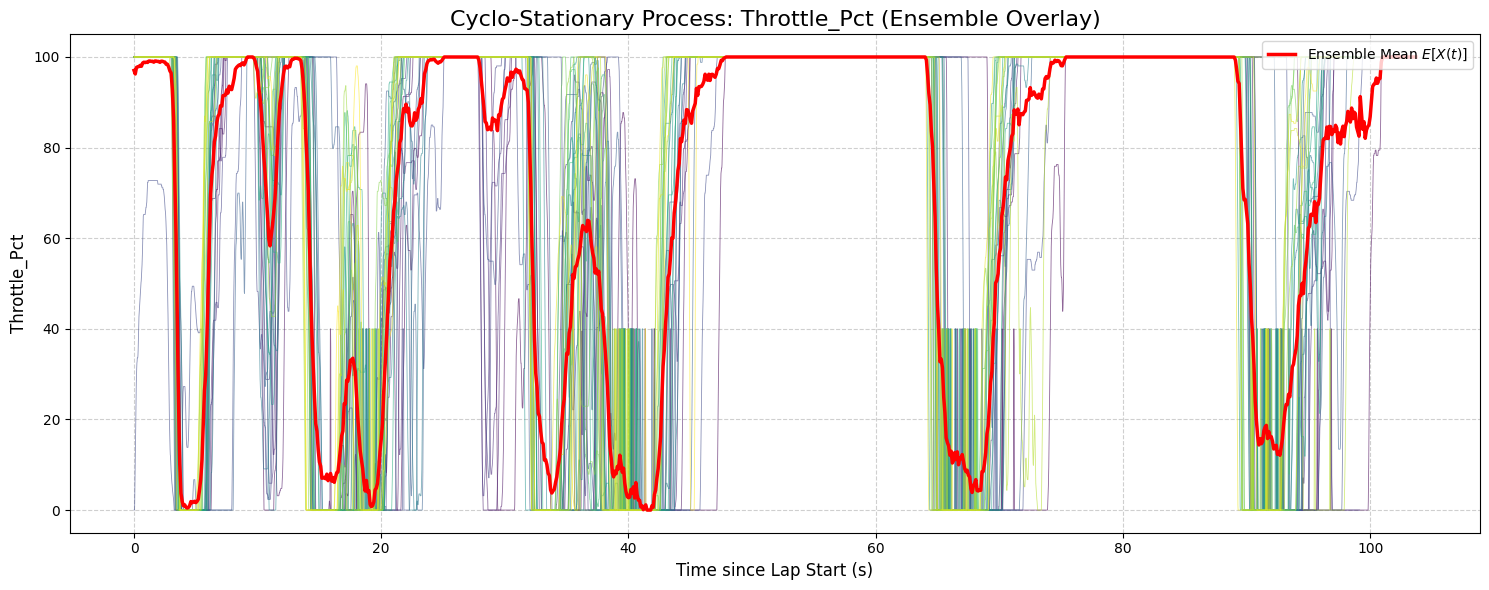

In [39]:
from matplotlib.ticker import FuncFormatter 

# --- Configuration ---
COL_TIME = 'SessionTime'      
COL_LAP = 'Lap'              
COL_VAR = 'Throttle_Pct'      

# Ensure we are working with the clean dataframe
max_lap = df_selected[COL_LAP].max()
df_analysis = df_selected[(df_selected[COL_LAP] > 0) & (df_selected[COL_LAP] < max_lap)].copy() 

print(f"[INFO] Analyzing Laps: {df_analysis[COL_LAP].unique()}")

# 1. Prepare Data: Calculate 'LocalLapTime'
df_analysis['LapStartTime'] = df_analysis.groupby(COL_LAP)[COL_TIME].transform('min')
df_analysis['LocalLapTime'] = df_analysis[COL_TIME] - df_analysis['LapStartTime']

def analyze_discrete_stationarity(df, lap_col, time_col):
    """
    Analyzes the Wide-Sense Stationarity (WSS) of the Lap Times {X_n}.
    Checks for constant Mean and Variance over time.
    """
    # 1. Prepare Data
    lap_times = df.groupby(lap_col)['LocalLapTime'].max()
    laps = lap_times.index
    times = lap_times.values

    # 2. Statistics
    mu = np.mean(times)
    sigma = np.std(times)

    # --- Helper: Time Formatter Function ---
    def format_time(seconds, _=None):
        """Converts seconds to mm:ss.ms format."""
        m = int(seconds // 60)
        s = int(seconds % 60)
        ms = int((seconds - int(seconds)) * 1000)
        return f"{m:02d}:{s:02d}.{ms:03d}"
    
    # 3. Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # --- Subplot 1: The Process X_n ---
    ax1.plot(laps, times, marker='o', linestyle='-', color='royalblue', label=r'Lap Time $X_n$')
    
    # Add Mean Line (Formatted in legend)
    mu_str = format_time(mu)
    ax1.axhline(mu, color='red', linestyle='--', linewidth=2, label=rf'Mean $\mu$ ({mu_str})')
    
    # Add Std Dev Range
    ax1.fill_between(laps, mu - sigma, mu + sigma, color='red', alpha=0.1, label=r'$\pm 1 \sigma$ Range')
    
    # --- AXIS FORMATTING (The Update) ---
    ax1.yaxis.set_major_formatter(FuncFormatter(format_time)) # Aplica o formatador ao eixo Y
    
    ax1.set_title(r'Discrete Process $\{X_n\}$: Lap Times', fontsize=14)
    ax1.set_xlabel('Lap Number (n)', fontsize=12)
    ax1.set_ylabel('Lap Time (mm:ss.ms)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # --- Subplot 2: PDF ---
    sns.histplot(times, kde=True, ax=ax2, bins=10, color='royalblue', edgecolor='black')
    ax2.set_title('Probability Density Function (PDF) Estimate', fontsize=14)
    ax2.set_xlabel('Lap Time (s)', fontsize=12) # Mantemos segundos aqui para leitura da distribuição
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    print(f"[RESULTS] Discrete Process {{X_n}} Statistics:")
    print(f"   - Mean (E[X]): {mu:.4f} s ({format_time(mu)})")
    print(f"   - Std Dev (sigma): {sigma:.4f} s")

def analyze_cyclostationarity(df, target_col):
    """
    Visualizes the Cyclo-Stationarity of the continuous signal X(t).
    """
    plt.figure(figsize=(15, 6))
    
    sns.lineplot(data=df, x='LocalLapTime', y=target_col, 
                 hue=COL_LAP, palette='viridis', 
                 linewidth=0.6, alpha=0.6, legend=None)
    
    df['TimeBin'] = df['LocalLapTime'].round(1) 
    ensemble_mean = df.groupby('TimeBin')[target_col].mean()
    
    plt.plot(ensemble_mean.index, ensemble_mean.values, 
             color='red', linewidth=2.5, label=r'Ensemble Mean $E[X(t)]$')
    
    plt.title(f'Cyclo-Stationary Process: {target_col} (Ensemble Overlay)', fontsize=16)
    plt.xlabel('Time since Lap Start (s)', fontsize=12)
    plt.ylabel(target_col, fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Execution ---
analyze_discrete_stationarity(df_analysis, COL_LAP, COL_TIME)
analyze_cyclostationarity(df_analysis, COL_VAR)

O Gráfico acima representa toda as realizações das 30 voltas da varíavel "pedal do acelerador (%)".

Alguns insights podem ser gerados a partir dele:

* Para cada linha colorida, é uma volta individual dada na pista de Charlotte. Elas representam a aleatoriedade. Nota-se que elas nunca são idênticas, de modo que em alguns lugares elas se sobrepõem perfeitamente (nas retas), e em outros elas se espalham (nas curvas).

* A Linha vermelha ($E[X(t)$): Esta é a Média do conjunto.Matematicamente, para cada instante de tempo $t$ (por exemplo, aos 10 segundos da volta), o código pegou o valor do acelerador de todas as 30 voltas e calculou a média. Ela representa o "comportamento esperado" do sistema. 

* Não-Estacionário: através da análise da média em vermelho,depende do tempo $t$, o processo não é estacionário.  Analisando outro por outro viés, se o processo fosse Estacionário (WSS), a linha vermelha seria uma reta horizontal (constante).

* 

## 